# Purpose

This notebook assess the variant calls from our 4 Exome samples produced from `variant_interpretation/bin/download_and_annotate_variants.py`

inputs:
  - `variants_csv_path`: path to outputted ready-to-analyze variants from `download_and_annotate_variants.py`

outputs:
  - Chart one: Assess variant quality scores by sample and group. Check if both groups show statistically different distributions of quality scores.
  - Chart two: Assess the frequency of filtered variants for the 4 samples.
  - Chart three: Assess the variant interpretations for the 4 samples.

In [1]:
# import 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import normaltest, mannwhitneyu
from statannotations.Annotator import Annotator


In [2]:
# inputs
variants_csv_path = '../../analysis/all_variants.csv'


In [3]:
sample_to_group_map_dict = {'JAS_N36': 'J Group',
                           'JAS_P18': 'J Group',
                           'M46': 'M Group',
                           'M48': 'M Group'}

In [4]:
variants_df = pd.read_csv(variants_csv_path).fillna('No classification')
variants_df.head(2)

,sample,chrom,pos,stop,ref,alts,qual,filter,clinical_significance,clinical_variant
0,JAS_N36,chr1,15820,15820,G,T,48.52,PASS,No classification,No classification
1,JAS_N36,chr1,16298,16298,C,T,43.77,PASS,No classification,No classification


In [5]:
def map_sample_to_group(sample, sample_to_group_map):
    if sample in sample_to_group_map:
        group_id = sample_to_group_map[sample]
    else:
        group_id = 'No Group Found'
    return group_id


def simplify_interpretation_names(variant):
    categorized_variant = variant # if no match, leave as is
    if 'pathogenic' in variant or 'Pathogenic' in variant:
        categorized_variant = 'Pathogenic'
    if 'benign' in variant or 'Benign' in variant or 'protective' in variant:
        categorized_variant = 'Benign'
    if 'uncertain' in variant or 'Uncertain' in variant:
        categorized_variant = 'Uncertain significance'
    if 'risk' in variant or 'association' in variant or 'Affects' in variant:
        categorized_variant = 'Risk factor'
    if 'drug' in variant or 'Drug' in variant:
        categorized_variant = 'Drug response'
    if 'not_provided' in variant or 'no_classification_for_the_single_variant' in variant:
        categorized_variant = 'No classification'
    if 'other' in variant or 'confers_sensitivity' in variant:
        categorized_variant = 'Other'
    return categorized_variant
    

In [6]:
variants_df['sample_group'] = variants_df['sample'].apply(lambda x: map_sample_to_group(x, sample_to_group_map_dict))

variants_df['Clinical_Interpretation'] = variants_df['clinical_significance'].apply(lambda x: simplify_interpretation_names(x))

In [7]:
variants_df.head(2)

,sample,chrom,pos,stop,ref,alts,qual,filter,clinical_significance,clinical_variant,sample_group,Clinical_Interpretation
0,JAS_N36,chr1,15820,15820,G,T,48.52,PASS,No classification,No classification,J Group,No classification
1,JAS_N36,chr1,16298,16298,C,T,43.77,PASS,No classification,No classification,J Group,No classification


J group is not a normal distribution: NormaltestResult(statistic=454277.4205493387, pvalue=0.0)
Thus, let's use a Mann Whitney test
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

J Group vs. M Group: Custom statistical test, P_val:0.000e+00


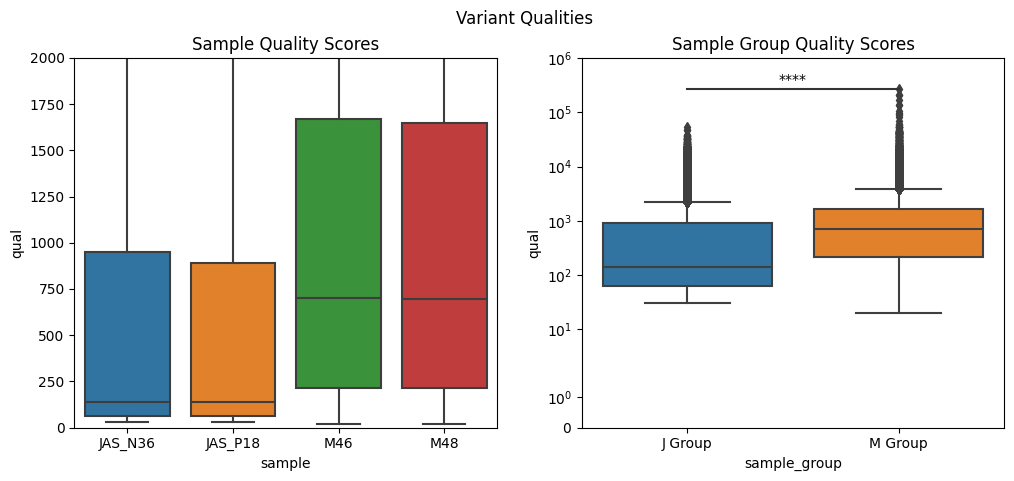

In [8]:
fig1, axes1 = plt.subplots(1,2)
fig1.set_figwidth(12)

# left chart
sns.boxplot(ax=axes1[0], data=variants_df, x='sample', y='qual')
axes1[0].set_ylim(0, 2000)
axes1[0].title.set_text('Sample Quality Scores')
fig1.suptitle('Variant Qualities')

# right chart
boxplot_kwargs = {'data':variants_df, 'x':'sample_group','y':'qual'}
sns.boxplot(ax=axes1[1], **boxplot_kwargs)
axes1[1].set_ylim(0, 2000)

J_quals = variants_df.query('sample_group == "J Group"')['qual'].values
M_quals = variants_df.query('sample_group == "M Group"')['qual'].values
print(f'J group is not a normal distribution: {normaltest(J_quals)}')
print('Thus, let\'s use a Mann Whitney test')

pairs = [('J Group', 'M Group')]
annotator = Annotator(axes1[1], pairs, **boxplot_kwargs)
pvalues = [
    mannwhitneyu(J_quals, M_quals, alternative='two-sided').pvalue,
]
annotator.set_pvalues(pvalues)
annotator.annotate()

axes1[1].set_yscale('symlog')
axes1[1].set_ylim(0,1000000)
axes1[1].title.set_text('Sample Group Quality Scores')



In [9]:
# Conclusion
print("""There's a clear segregation between the 'JAS' and 'M' prefix samples. 
By a Mann Whitney test, I find the two group variant quality distributions to be significantly different. 
""")

There's a clear segregation between the 'JAS' and 'M' prefix samples. 
By a Mann Whitney test, I find the two group variant quality distributions to be significantly different. 



Interesting. Looks like the J group samples don't have filters. Seems like there is some dissimilarity between these two groups.


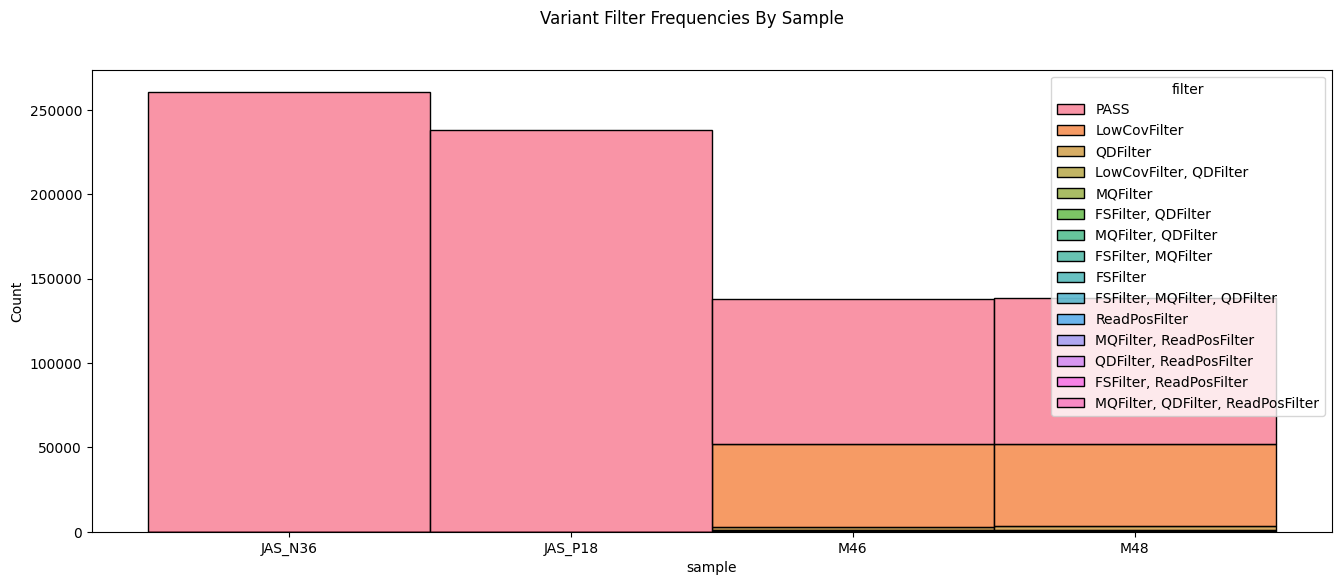

In [10]:
fig2, axes2 = plt.subplots(1,1)
sns.histplot(ax=axes2, data=variants_df, x='sample', hue='filter', multiple='stack')
fig2.set_figheight(6)
fig2.set_figwidth(16)
fig2.suptitle('Variant Filter Frequencies By Sample')

print(r"Interesting. Looks like the J group samples don't have filters. Seems like there is some dissimilarity between these two groups.") 

Seems like the vast majority of variants are not classified. 
However, when we look variants that were, we see some interesting trends. 
It looks like we discovered far more pathogenic variants in the J Group samples than the M group.


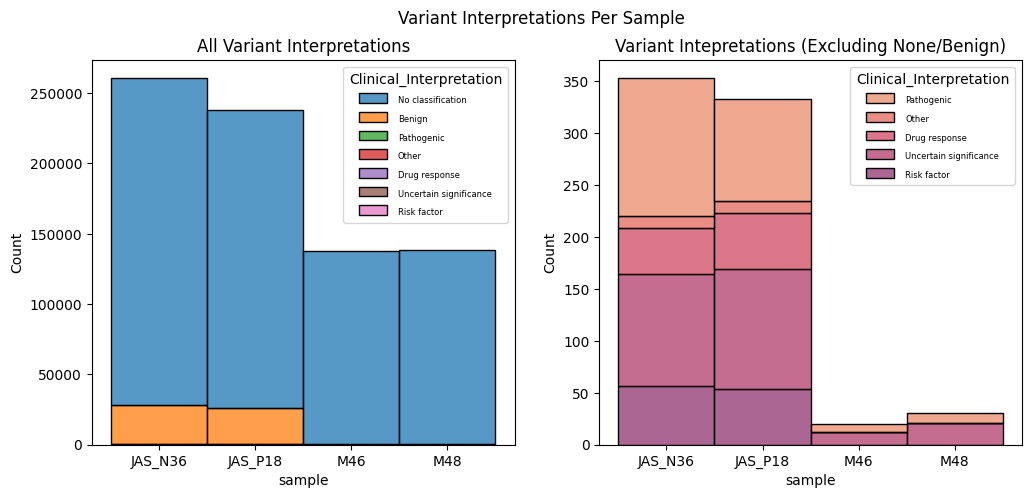

In [11]:
fig3, axes3 = plt.subplots(1,2)
axes3_plot_1 = sns.histplot(ax=axes3[0], data=variants_df, x='sample', hue='Clinical_Interpretation', multiple='stack')
interp_exclude_list = ['No classification', 'Benign']
sns.set_palette("flare")
axes3_plot_2 = sns.histplot(ax=axes3[1], data=variants_df.query('Clinical_Interpretation not in @interp_exclude_list'), x='sample', hue='Clinical_Interpretation', multiple='stack')
plt.setp(axes3_plot_1.get_legend().get_texts(), fontsize='6')  
plt.setp(axes3_plot_2.get_legend().get_texts(), fontsize='6')  
fig3.set_figwidth(12)
fig3.set_figheight(5)
fig3.suptitle('Variant Interpretations Per Sample')
axes3[0].title.set_text('All Variant Interpretations')
axes3[1].title.set_text('Variant Intepretations (Excluding None/Benign)')

print("""Seems like the vast majority of variants are not classified. 
However, when we look variants that were, we see some interesting trends. 
It looks like we discovered far more pathogenic variants in the J Group samples than the M group.""")